# Argo finestructure estimates

In [1]:
%load_ext watermark

import argopy
import cf_xarray as cfxr
import dask
import dcpy
import gsw
import matplotlib as mpl
import matplotlib.pyplot as plt
import mixsea
import numpy as np
import pandas as pd
import scipy
import scipy.integrate
import seawater as sw
import xarray as xr
from dcpy.finestructure import estimate_turb_segment
from scipy import signal
from scipy.io import loadmat

from eddydiff import argomix

plt.style.use("bmh")
mpl.rcParams["figure.dpi"] = 140
mpl.rcParams["lines.linewidth"] = 1
dirname = "/home/deepak/datasets/finestructure/"

%watermark -iv

dask      : 2021.6.2
cf_xarray : 0.4.1.dev21+gab9dc66
scipy     : 1.5.3
eddydiff  : 0.1
pandas    : 1.2.3
seawater  : 3.3.4
dcpy      : 0.1
mixsea    : 0.1.0
xarray    : 0.17.1.dev3+g48378c4b1
numpy     : 1.20.2
argopy    : 0.1.7
gsw       : 3.4.0
matplotlib: 3.4.1



In [5]:
from distributed import Client

client = Client(threads_per_worker=7, memory_limit="24GB", processes=False)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://192.168.0.10:8787/status,
Status: running,Using processes: False
Dashboard: http://192.168.0.10:8787/status,Workers: 1
Total threads: 7,Total memory: 22.35 GiB
Comm: inproc://192.168.0.10/1554493/1,Workers: 1
Dashboard: http://192.168.0.10:8787/status,Total threads: 7
Started: Just now,Total memory: 22.35 GiB
Comm: inproc://192.168.0.10/1554493/3,Total threads: 7
Dashboard: http://192.168.0.10:35059/status,Memory: 22.35 GiB
Nanny: None,


## NATRE region

In [80]:
import glob

dsets = [xr.open_dataset(file) for file in glob.glob("./argo_natre_*.nc")]
argo = (
    xr.concat(dsets, dim="N_POINTS").load().argo.point2profile().set_coords("PRES")
)  # .isel(N_POINTS=slice(10000))
argo.PRES.attrs["standard_name"] = "sea_water_pressure"
argo.PRES.attrs["positive"] = "down"

Text(0, 0.5, 'N_OBS')

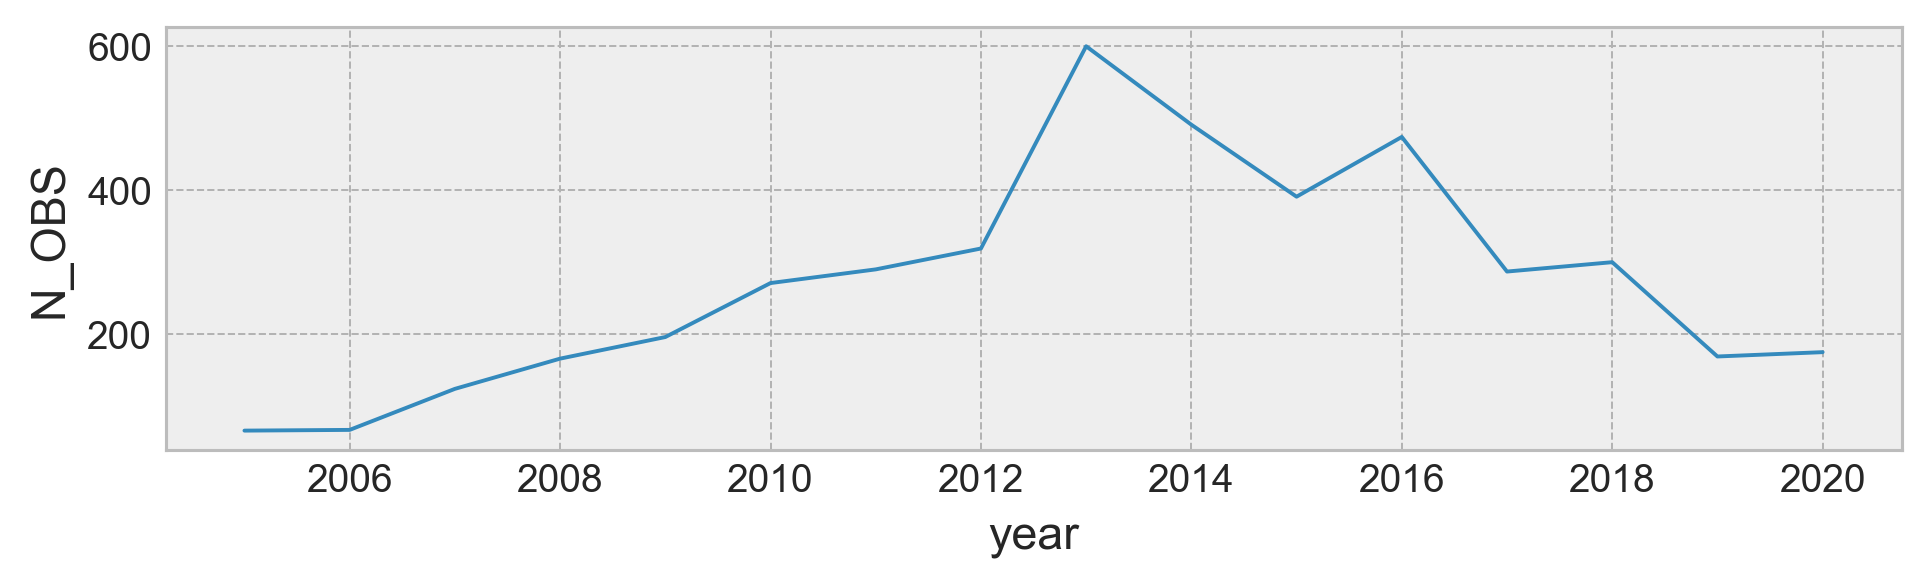

In [81]:
argo.TIME.groupby(argo.TIME.dt.year).count().plot()
plt.gcf().set_size_inches((8, 2))
plt.gca().set_ylabel("N_OBS")

In [82]:
import dask

argo_good = argo.query({"N_PROF": "DIRECTION == 'A' & DATA_MODE == 'D'"})

# doesn't do anything
# too_coarse = (argo_good.PRES.diff("N_LEVELS") > 20).all("N_LEVELS")
# argo_good = argo_good.isel(N_PROF=~too_coarse)

tasks = [
    dask.delayed(argomix.process_profile)(argo_good.isel(N_PROF=idx))
    for idx in range(argo_good.sizes["N_PROF"])
]
len(tasks)

3885

In [9]:
results = dask.compute(tasks, scheduler=client)

distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://192.168.0.10/1554493/1 remote=inproc://192.168.0.10/1554493/8>
/home/deepak/work/python/dcpy/dcpy/finestructure.py:86: RuntimeWarning: invalid value encountered in sqrt
  N = np.sqrt(N2fit.mean()).item()


In [10]:
def set_index(ds, dim):
    ds = ds.assign_coords({dim: np.arange(ds.sizes[dim])})
    ds["pressure"] = ds.variables["pressure"].to_base_variable()
    return ds


renamed = [
    ds.rename_dims({"pressure": "pressure_"})
    .pipe(set_index, "pressure_")
    .expand_dims("profile")
    for ds in results[0]
    if isinstance(ds, xr.Dataset)
]

In [11]:
combined = xr.concat(renamed, dim="profile", join="outer")
combined.pressure.attrs["positive"] = "down"
combined

<xarray.Dataset>
Dimensions:                (pressure_: 20, profile: 3583, nbnds: 2)
Coordinates: (12/13)
  * pressure_              (pressure_) int64 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
    flag                   (profile, pressure_) float64 -1.0 -1.0 ... -1.0 nan
    pressure               (profile, pressure_) float64 nan nan nan ... nan nan
    npts                   (profile, pressure_) float64 0.0 0.0 0.0 ... 0.0 nan
    γmean                  (profile, pressure_) float64 nan nan nan ... nan nan
    latitude               (profile) float64 23.08 23.79 23.11 ... 26.0 27.96
    ...                     ...
    γ_bounds               (profile, pressure_, nbnds) float64 nan nan ... nan
    p_bounds               (profile, pressure_, nbnds) float64 nan nan ... nan
    CONFIG_MISSION_NUMBER  (profile) int64 1 1 1 1 1 1 1 1 1 ... 5 4 2 5 2 2 5 2
    PLATFORM_NUMBER        (profile) int64 1900073 1900072 ... 4901585 6902572
    CYCLE_NUMBER           (profile) int64 103 104 104 105 ... 180 181 229 182
    DIRECTION              <U1 'A'
Dimensions without coordinates: profile, nbnds
Data variables: (12/14)
    ε                      (profile, pressure_) float64 nan nan nan ... nan nan
    Kρ                     (profile, pressure_) float64 nan nan nan ... nan nan
    N2mean                 (profile, pressure_) float64 nan nan nan ... nan nan
    ξvar                   (profile, pressure_) float64 nan nan nan ... nan nan
    ξvargm                 (profile, pressure_) float64 nan nan nan ... nan nan
    Tzlin                  (profile, pressure_) float64 nan nan nan ... nan nan
    ...                     ...
    Tmld                   (profile) float64 112.4 95.1 112.3 ... 77.88 89.6
    σmld                   (profile) float64 92.4 95.1 112.3 ... 80.2 77.88 89.6
    Tmode                  (profile) float64 132.5 135.3 132.2 ... 79.96 99.7
    σmode                  (profile) float64 132.5 115.1 132.2 ... 79.96 99.7
    χ                      (profile, pressure_) float64 nan nan nan ... nan nan
    KtTz                   (profile, pressure_) float64 nan nan nan ... nan nan

In [21]:
combined.to_zarr("./argomix_natre.zarr")

distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


In [ ]:
combined.to_netcdf("argomix_natre_all_latest.nc")

In [19]:
# combined = xr.open_dataset("argomix_natre_all.nc")
combined = xr.open_zarr("./argomix_natre.zarr").load()
bins = [
    26.692,
    26.876,
    27.039,
    27.163,
    27.288,
    27.406,
    27.516,
    27.605,
    27.683,
    27.742,
    27.794,
    27.835,
    27.872,
    27.898,
    27.921,
    27.94,
    27.958,
    29,
]

In [20]:
combined.coords["γ_vertices"] = cfxr.bounds_to_vertices(
    combined.γ_bounds, bounds_dim="nbnds", core_dims=["pressure_"]
)
combined.coords["p_vertices"] = cfxr.bounds_to_vertices(
    combined.p_bounds, bounds_dim="nbnds", core_dims=["pressure_"]
)

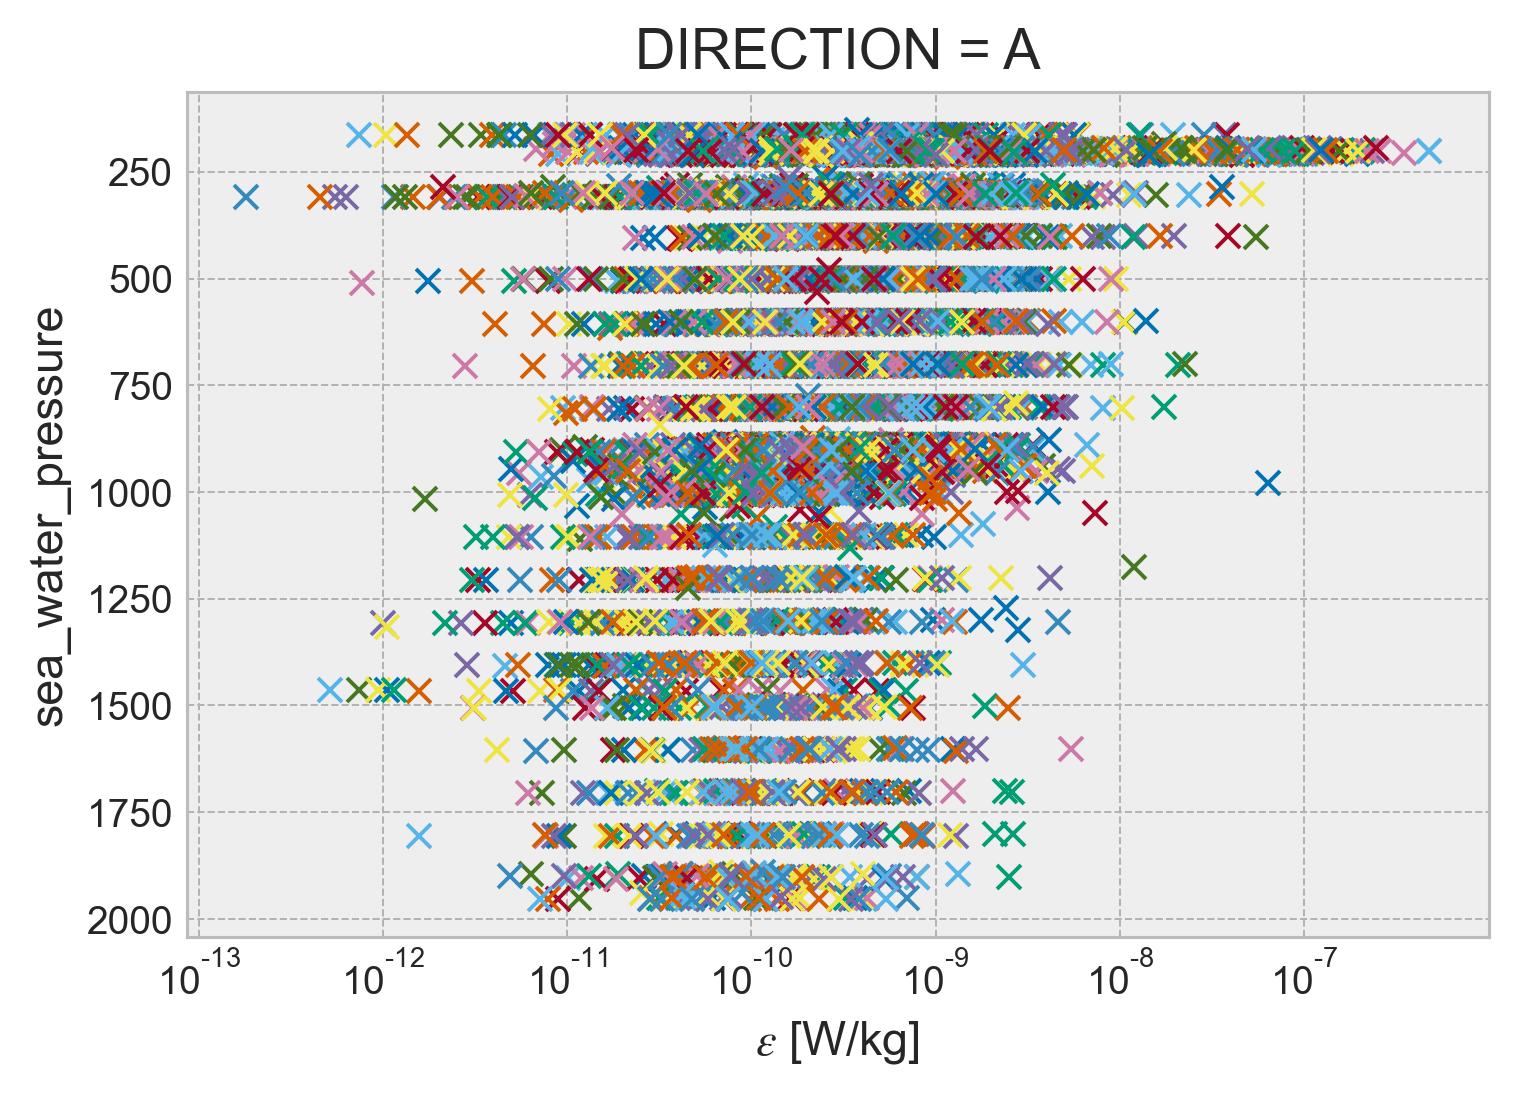

In [21]:
good_data = combined.npts > 40
combined.ε.cf.plot(
    hue="profile",
    y="pressure",
    xscale="log",
    ls="none",
    marker="x",
    add_legend=False,
    yincrease=False,
);

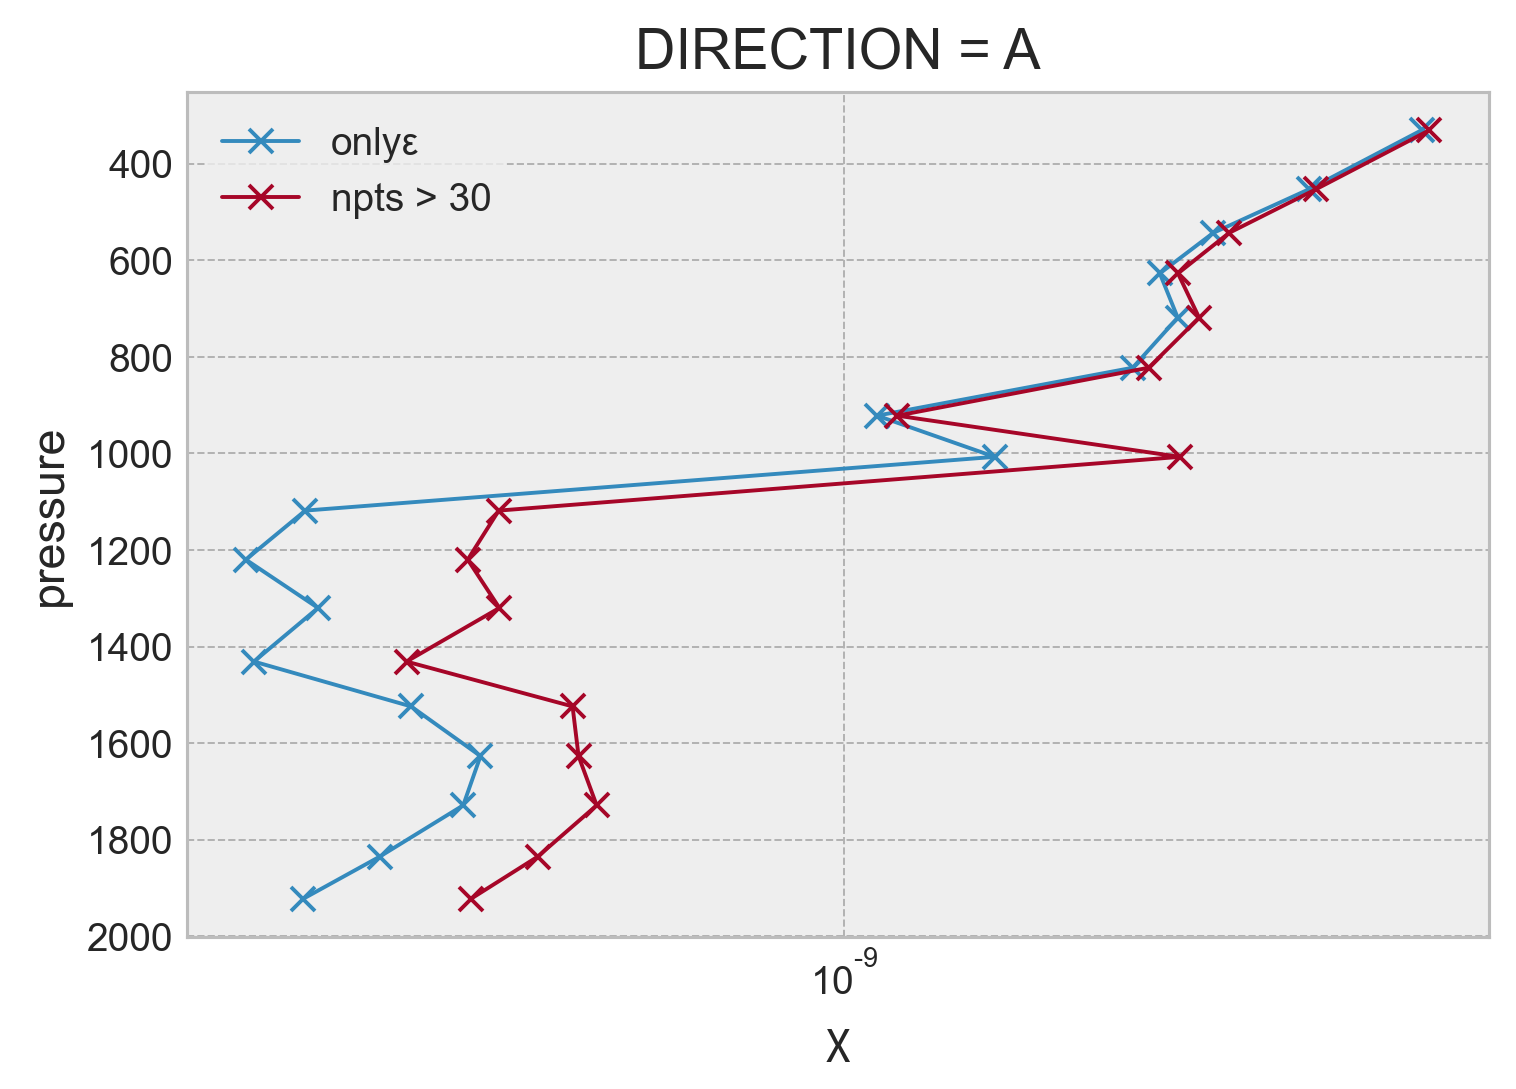

In [22]:
combined.reset_coords("pressure").groupby_bins("γmean", bins=bins).mean().set_coords(
    "pressure"
).χ.plot(y="pressure", marker="x", xscale="log", yincrease=False)
combined.where(combined.npts > 20).reset_coords("pressure").groupby_bins(
    "γmean",
    bins=bins,
).mean().set_coords("pressure").χ.plot(
    y="pressure", marker="x", xscale="log", yincrease=False
)
plt.legend(["onlyε", "npts > 30"])
plt.grid(True)

### Experiment with conservative interpolation of ε

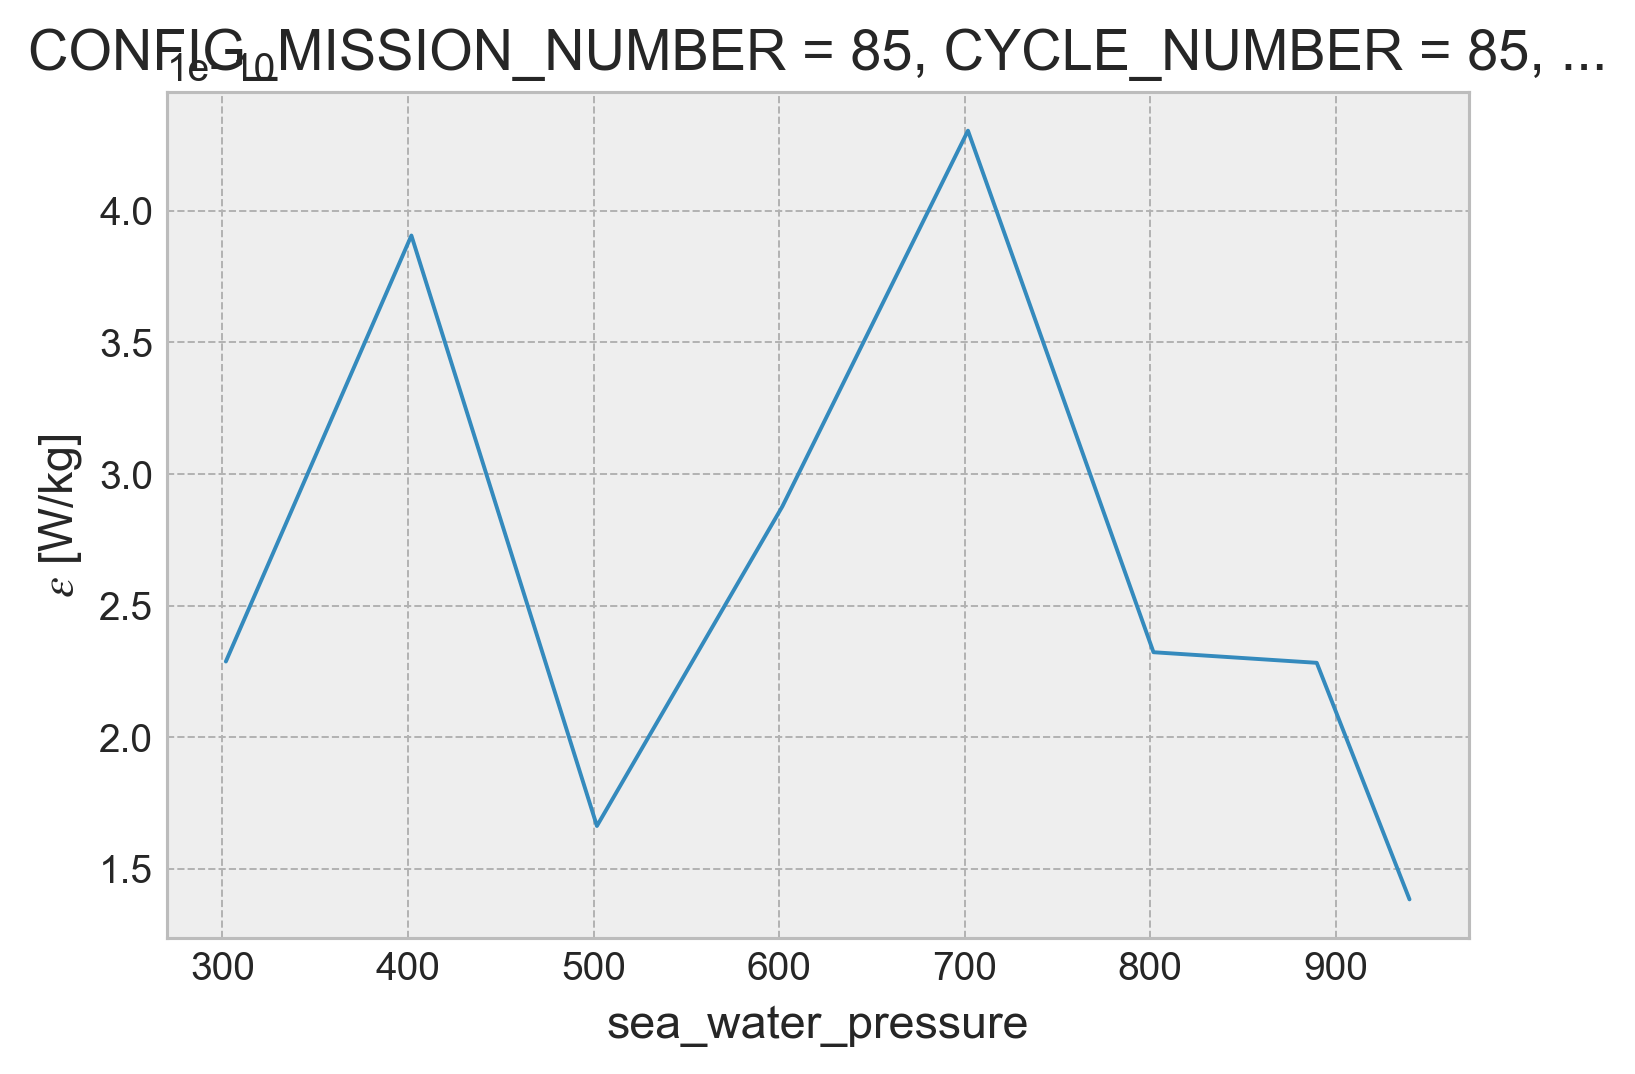

In [13]:
profile = combined.isel(profile=1950)
profile.ε.plot(x="pressure")

In [87]:
mask = profile.ε.notnull().data
mask_outer = profile.γ_vertices.notnull().data

In [78]:
bins = np.array(bins)

eps_ext = transform.interp_1d_conservative(
    (profile.ε * profile.γmean * profile.pressure).data[mask][:-1],
    profile.γ_vertices.data[mask_outer],
    target_theta_bins=np.asarray(bins),
)
mass_ext = transform.interp_1d_conservative(
    (profile.γmean * profile.pressure).data[mask][:-1],
    profile.γ_vertices.data[mask_outer],
    target_theta_bins=bins,
)

plt.plot((bins[:-1] + bins[1:]) / 2, eps_ext / mass_ext)
plt.plot(profile.γmean, profile.ε)

NameError: name 'transform' is not defined

### Do variance budget terms

This does not work so well or too well actually. It looks like χ/2 matches the local turbulent stirring production exactly!

I think the 200m averaging scale in the finestructure estimate is the problem. It matches the vertical scale for our 'large-scale' vertical bins (I think the spacing between γ surfaces, but should check).

Another option is to do the Ferrari & Polzin (2005) thing where they set microscale stirring production $= Γ⟨ε⟩/N^2_m θ^m_z$; so I could bin-average fine structure ε to get $⟨ε⟩$ and use the climatology to get the gradient terms. 

Another option is to calculate the estimates in 200m bins and then average all estimates in those bins; this would avoid some extra averaging I think (!)

- **Why has no one done this before?**

In [6]:
import cf_xarray
import dcpy

argoclim = dcpy.oceans.read_argo_clim().sel(
    lat=slice(24, 28), lon=slice(360 - 31, 360 - 26)
)
argoclim["γ"] = dcpy.oceans.neutral_density(argoclim[["Tmean", "Smean"]])
argoclim.load()
argoclim.cf

Coordinates:
- CF Axes: * X: ['lon']
           * Y: ['lat']
           * Z: ['pres']
           * T: ['time']

- CF Coordinates: * longitude: ['lon']
                  * latitude: ['lat']
                  * vertical: ['pres']
                  * time: ['time']

- Cell Measures:   area, volume: n/a

- Standard Names: * sea_water_pressure: ['pres']

- Bounds:   n/a

Data Variables:
- Cell Measures:   area, volume: n/a

- Standard Names:   neutral_density: ['γ']
                    sea_water_potential_temperature: ['theta_mean']
                    sea_water_salinity: ['S', 'Smean']
                    sea_water_temperature: ['T', 'Tmean']

- Bounds:   n/a

### density bin averaged

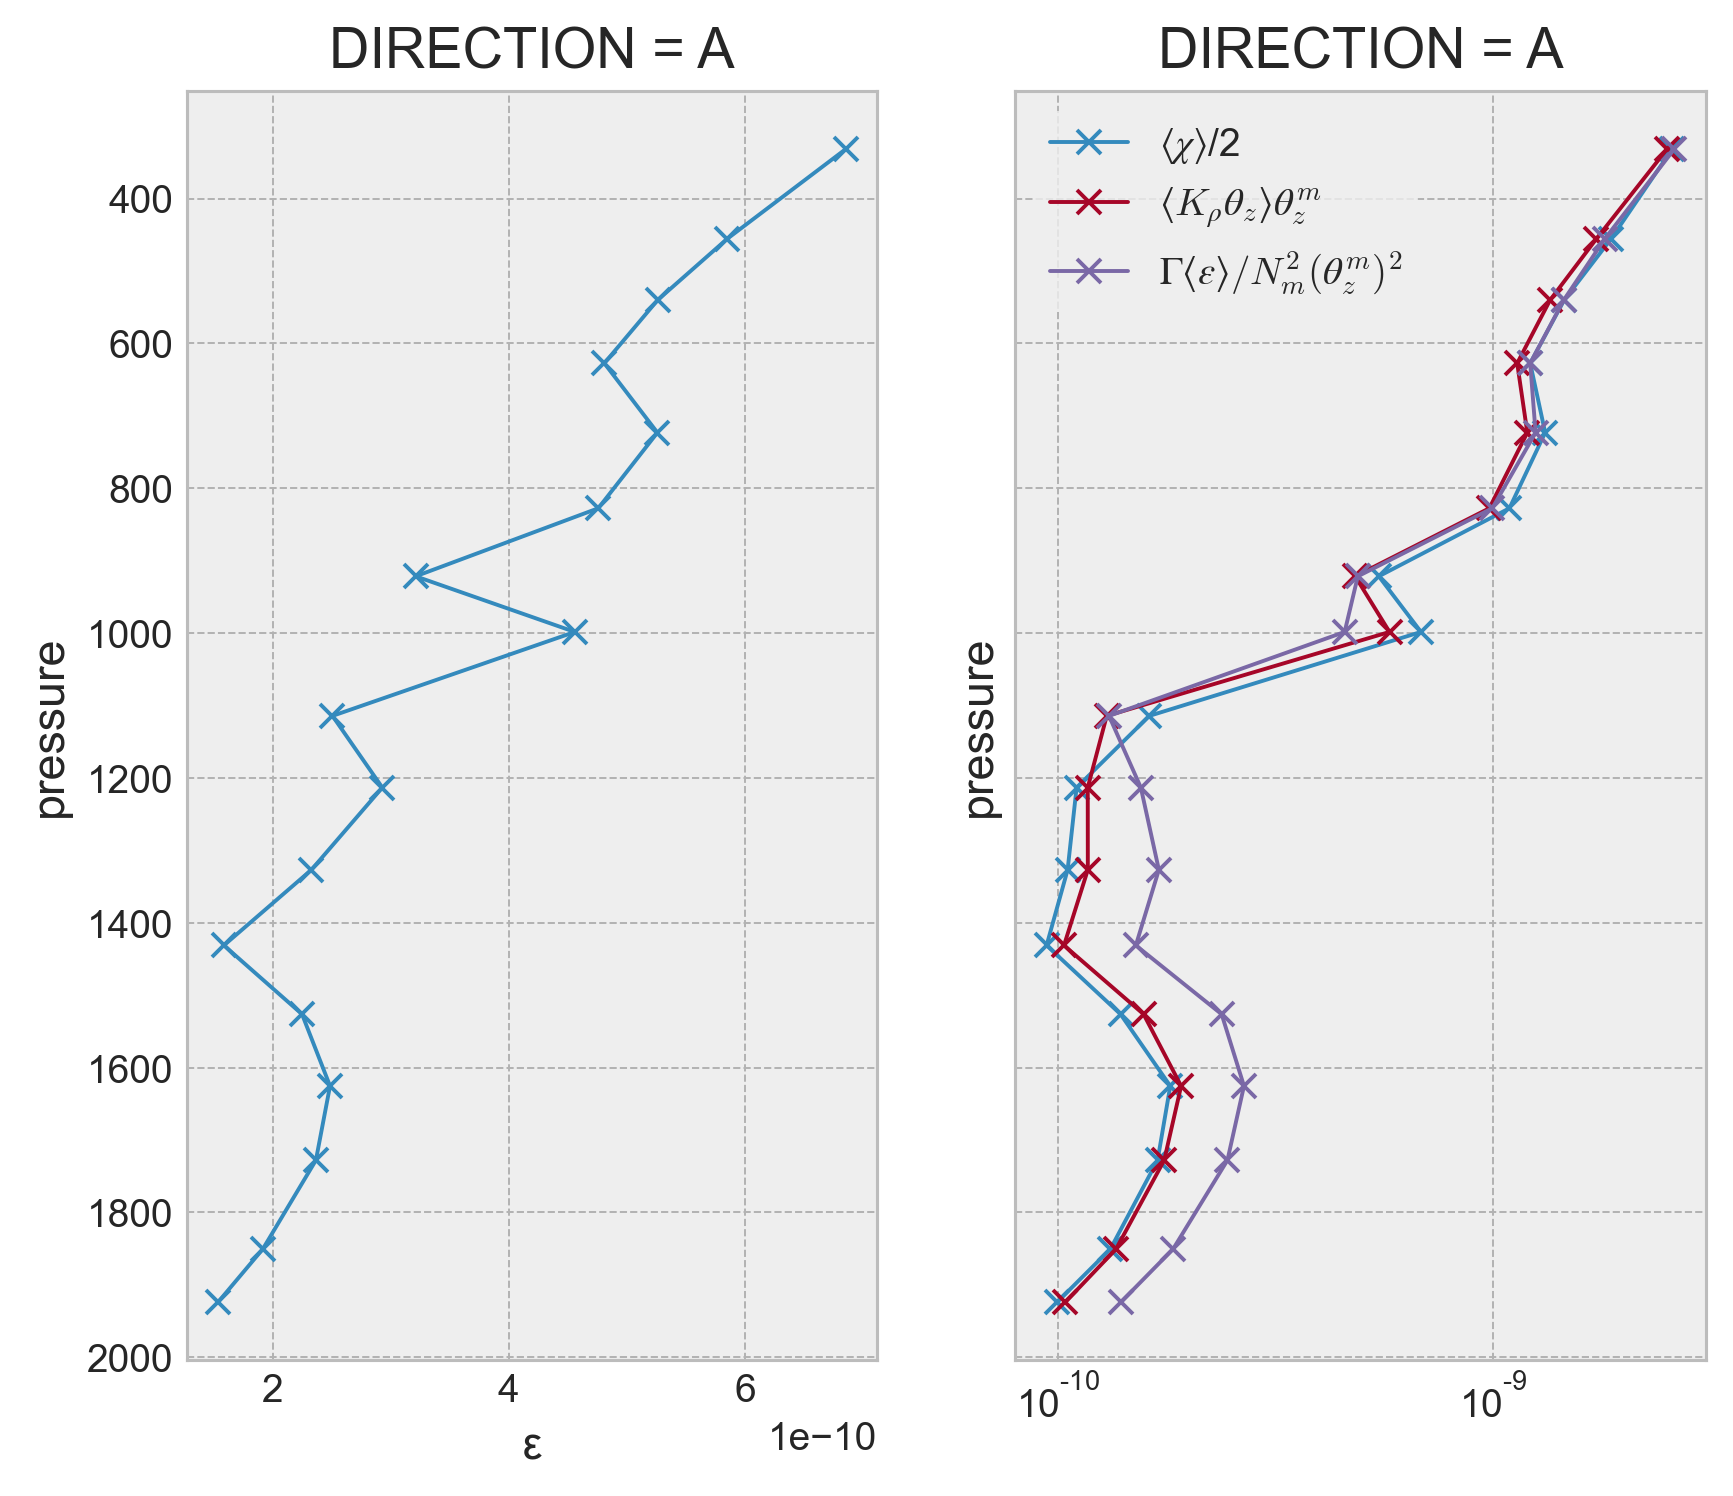

In [23]:
bins = np.array(
    [
        26.69,
        26.88,
        27.04,
        27.16,
        27.29,
        27.41,
        27.52,
        27.6,
        27.68,
        27.74,
        27.79,
        27.84,
        27.87,
        27.9,
        27.92,
        27.94,
        27.96,
        27.97,
    ]
)
# bins = np.arange(26.5, 28.1, 0.15)

combined["KtTz_seg"] = combined.Kρ * combined.mean_dTdz_seg
binned_argo_fs = (
    combined.reset_coords("pressure")  # .where(good_data & (combined.npts > 30))
    .groupby_bins(
        "γmean",
        bins=bins,
    )
    .mean()
    .set_coords("pressure")
)


# totally fine
Tz_m_argo = (
    argoclim.theta_mean.cf.differentiate("pres", positive_upward=True)
    .compute()
    .mean(["lat", "lon"])
    .interp(pres=binned_argo_fs.pressure)
)
N2_m_argo = (
    -9.81
    / 1025
    * (
        argoclim.γ.cf.differentiate("pres", positive_upward=True)
        .compute()
        .mean(["lat", "lon"])
        .interp(pres=binned_argo_fs.pressure)
    )
)


f, ax = plt.subplots(1, 2, sharey=True)

binned_argo_fs.ε.cf.plot(marker="x", y="pressure", ax=ax[0])

(binned_argo_fs.χ / 2).plot(
    ax=ax[1], y="pressure", marker="x", xscale="log", yincrease=False
)
(binned_argo_fs.KtTz * Tz_m_argo).plot(ax=ax[1], y="pressure", marker="x")
# (binned_argo_fs.KtTz_seg * Tz_m_argo).plot(ax=ax[1], y="pressure", marker="o")
(0.2 * binned_argo_fs.ε / N2_m_argo * Tz_m_argo ** 2).plot(
    ax=ax[1], y="pressure", marker="x"
)
plt.legend(["$⟨χ⟩$/2", "$⟨K_ρ θ_z⟩ θ_z^m$", "$Γ⟨ε⟩/N^2_m (θ^m_z)^2$"])
plt.gcf().set_size_inches((7, 6))
plt.grid(True)

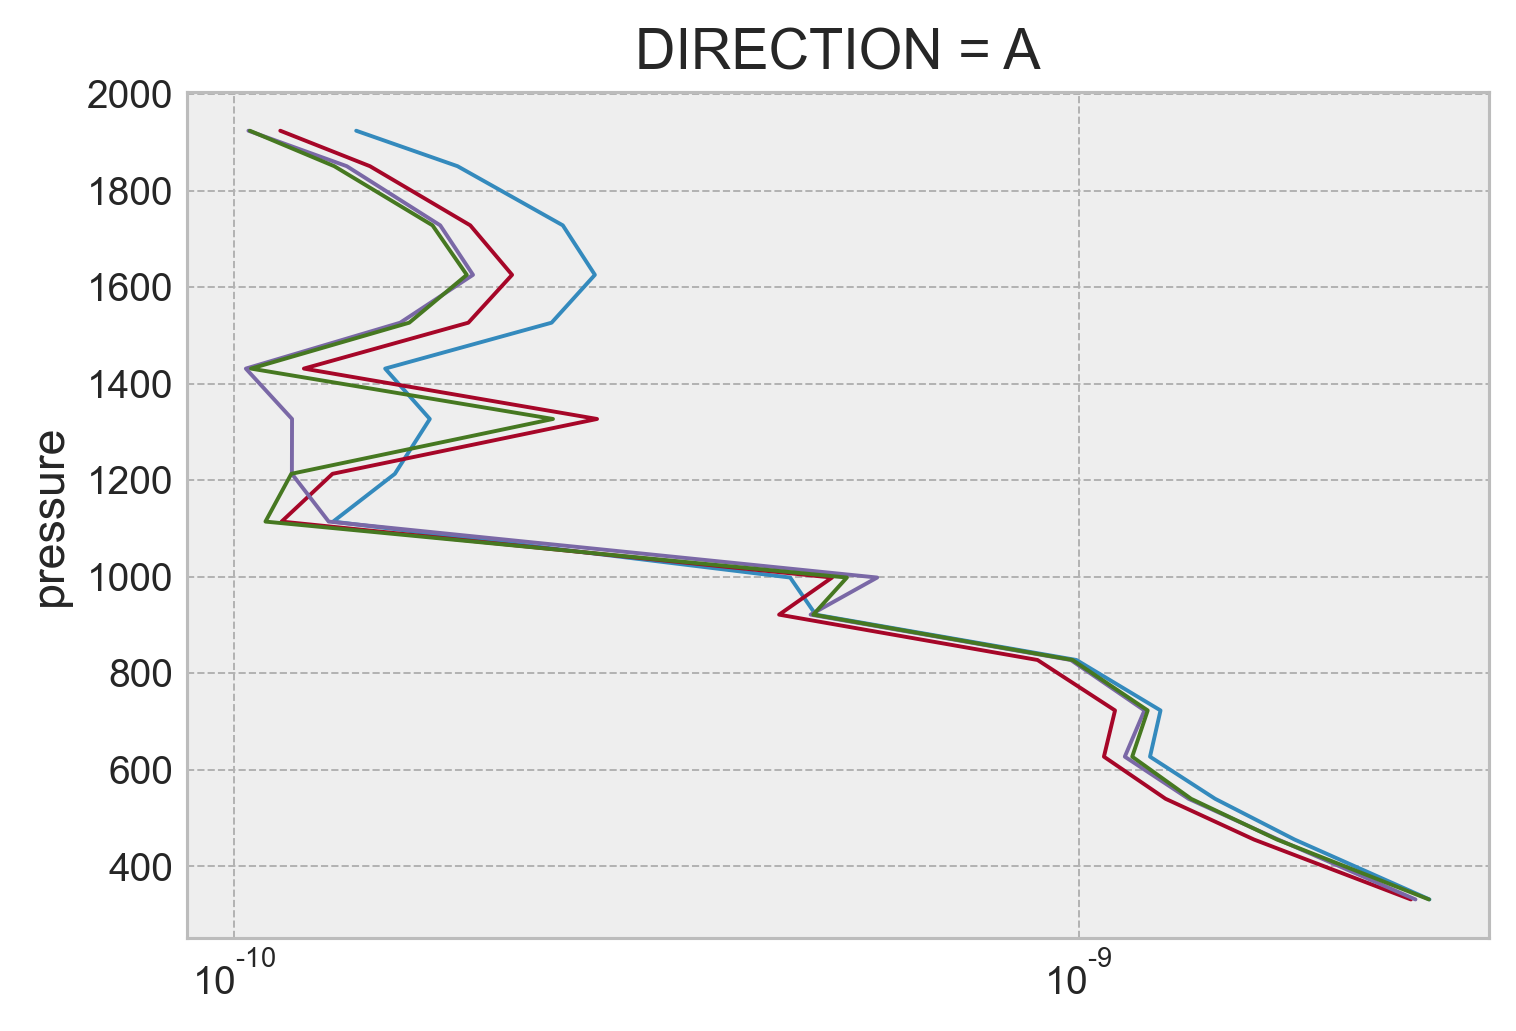

In [15]:
(0.2 * binned_argo_fs.ε / N2_m_argo * Tz_m_argo ** 2).plot(y="pressure")
(binned_argo_fs.Kρ * Tz_m_argo ** 2).plot(y="pressure", xscale="log")
(binned_argo_fs.KtTz * Tz_m_argo).plot(y="pressure", xscale="log")
(binned_argo_fs.Kρ * binned_argo_fs.Tzmean * Tz_m_argo).plot(y="pressure", xscale="log")

### pressure bin averaged

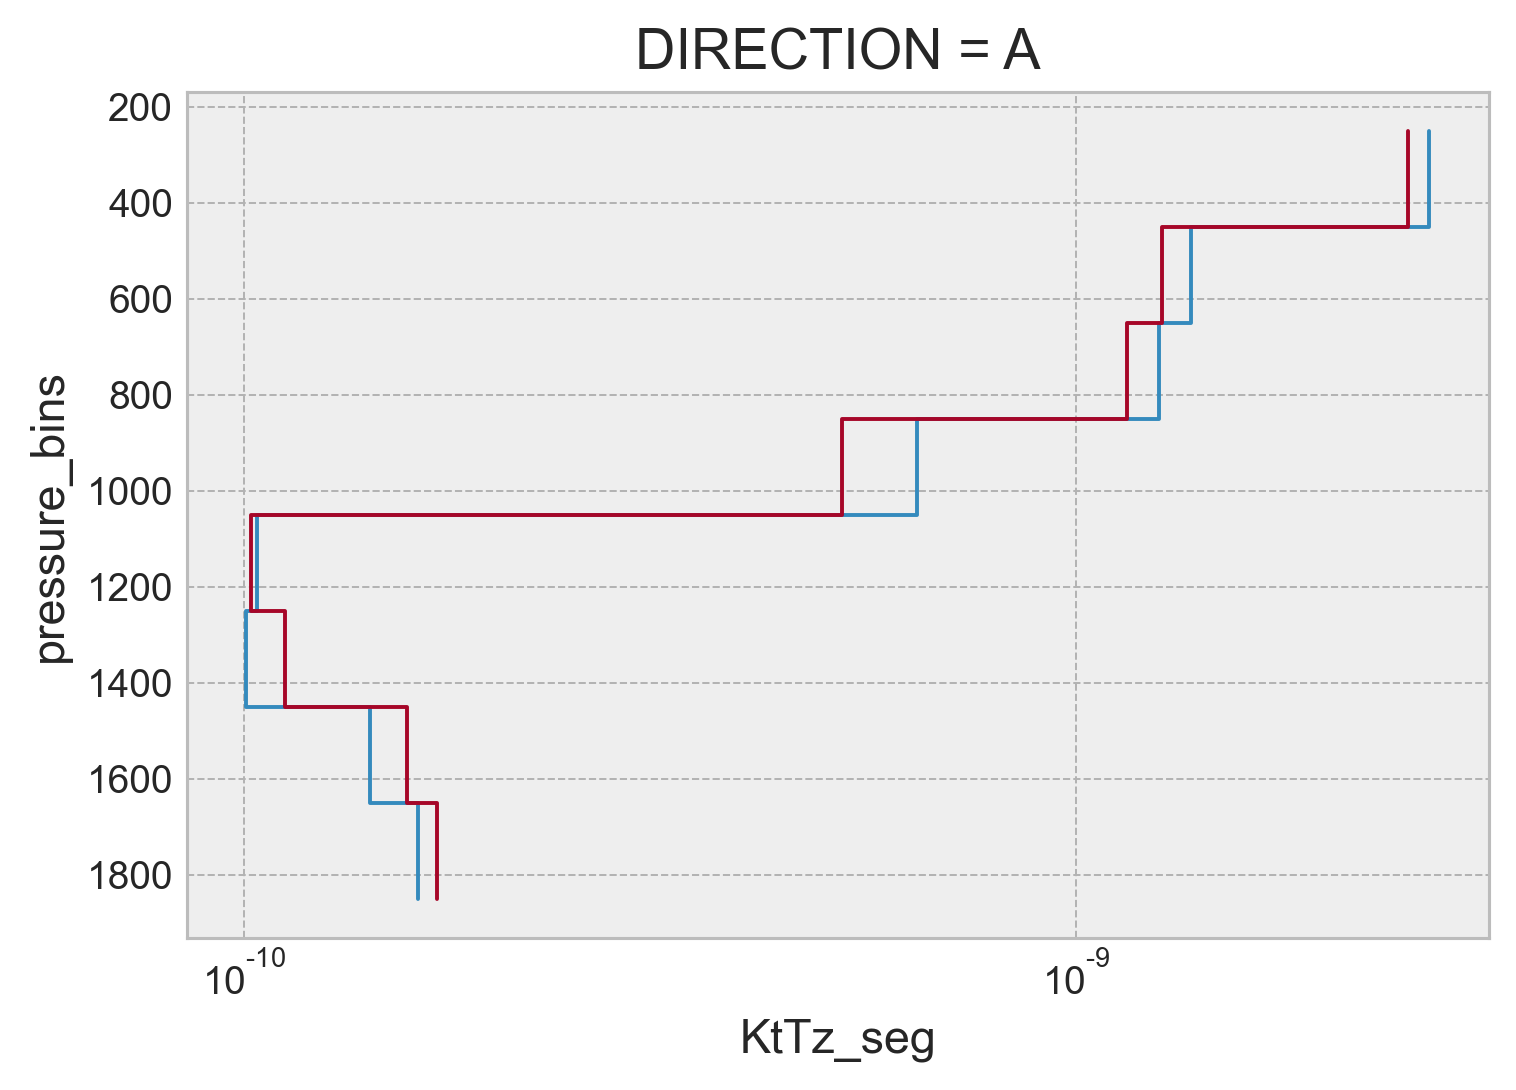

In [73]:
binned = combined.groupby_bins("pressure", np.arange(250, 2050, 200)).mean()
centers = [p.data.item().mid for p in binned.pressure_bins]
Tz_m_argo = (
    argoclim.theta_mean.cf.differentiate("pres", positive_upward=True)
    .compute()
    .mean(["lat", "lon"])
    .interp(pres=centers)
    .rename(pres="pressure_bins")
)

(binned.χ / 2).plot.step(y="pressure_bins", xscale="log", yincrease=False)
(binned.KtTz_seg * Tz_m_argo.data).plot.step(
    y="pressure_bins", xscale="log", yincrease=False
)

## Debugging profile estimates

- [x] check MLD for N_PROF=100
- [ ] change axes tick colors for T,S,γ
- [ ] Throw out estimates when number of points is small. This is causing the drop near 1000m; below this data spacing is usually coarse. I need to be more careful about bins near 1000m

 104 —  294dbar: ξgmvar: 0.103, ξvar: 0.114, N2: 3.61e-05 K: 5.33e-06, ε: 9.45e-10
 204 —  385dbar: ξgmvar: 0.096, ξvar: 0.033, N2: 2.28e-05 K: 4.97e-07, ε: 5.56e-11


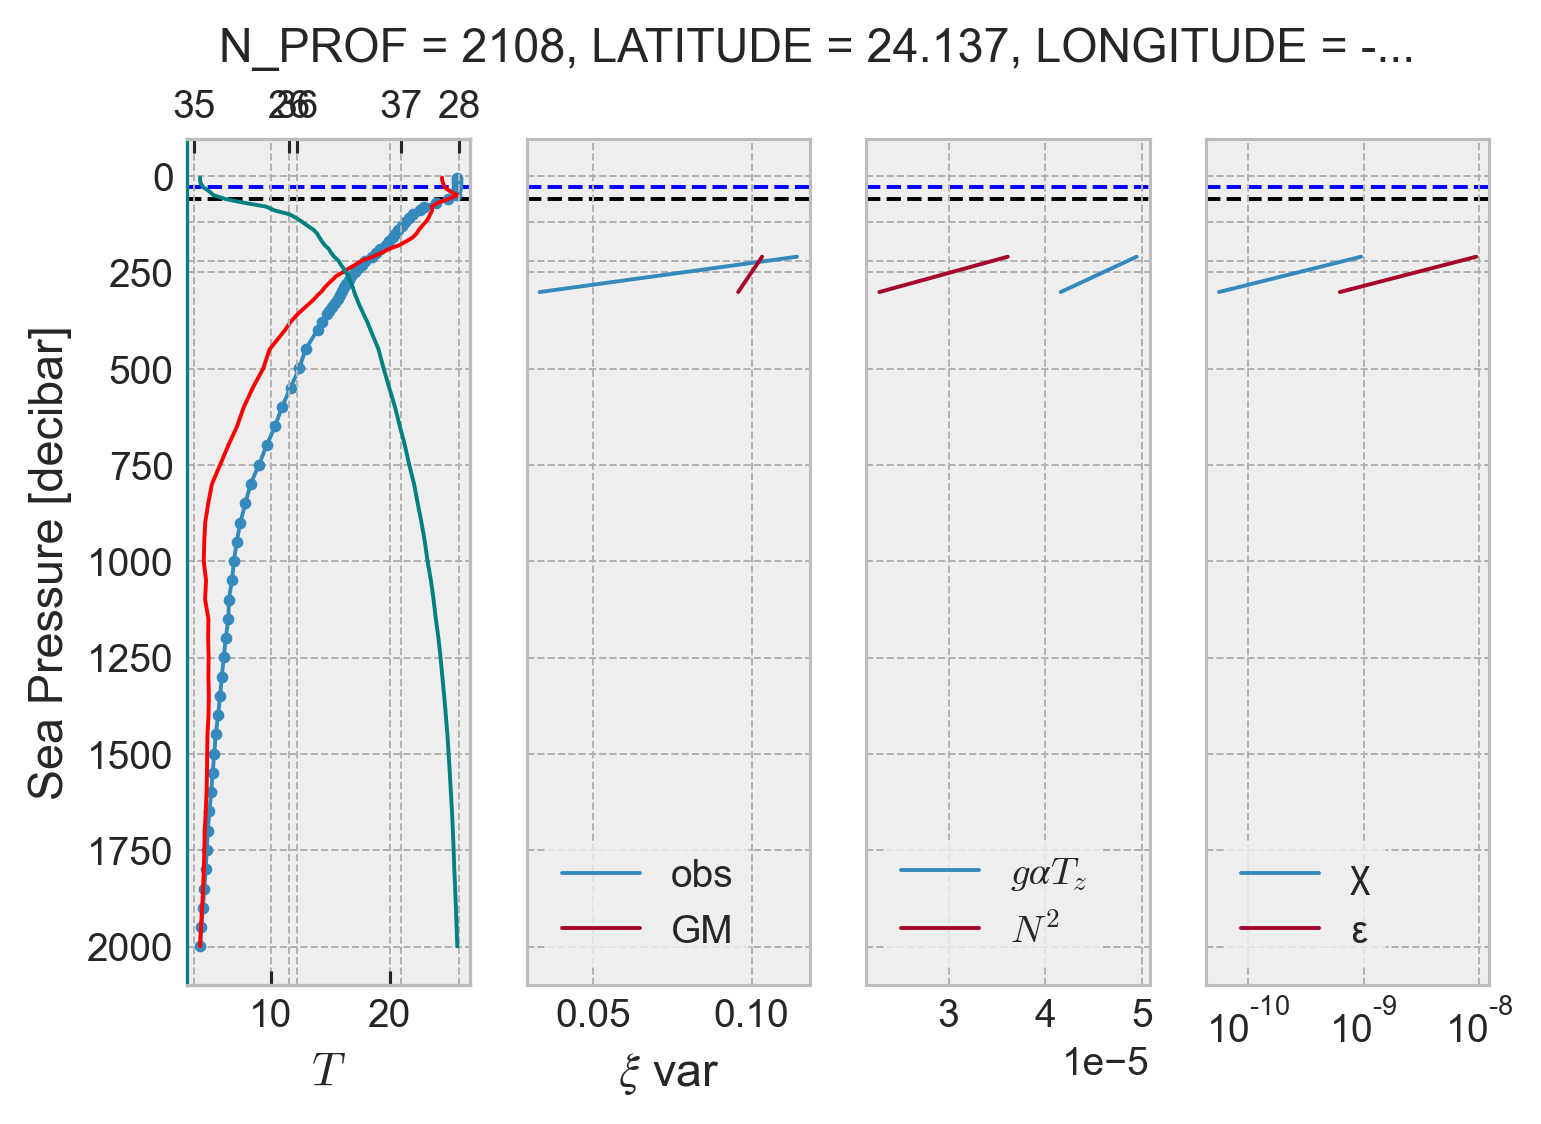

In [278]:
profile = argo.isel(N_PROF=120)
result = argomix.process_profile(profile, debug=True)

 221 —  371dbar: ξgmvar: 0.102, ξvar: 0.024, N2: 2.27e-05 K: 2.14e-07, ε: 2.38e-11
 336 —  476dbar: ξgmvar: 0.045, ξvar: 0.021, N2: 1.88e-05 K: 8.32e-07, ε: 7.67e-11
 436 —  586dbar: ξgmvar: 0.104, ξvar: 0.005, N2: 1.55e-05 K: 1.01e-08, ε: 7.68e-13
 521 —  691dbar: ξgmvar: 0.111, ξvar: 0.187, N2: 1.42e-05 K: 1.09e-05, ε: 7.58e-10
 621 —  791dbar: ξgmvar: 0.111, ξvar: 0.051, N2: 1.27e-05 K: 8.11e-07, ε: 5.06e-11
 721 —  891dbar: ξgmvar: 0.112, ξvar: 0.085, N2: 1.01e-05 K: 2.12e-06, ε: 1.05e-10
 821 —  991dbar: ξgmvar: 0.107, ξvar: 0.153, N2: 7.79e-06 K: 7.40e-06, ε: 2.82e-10
 921 — 1091dbar: ξgmvar: 0.113, ξvar: 0.049, N2: 7.36e-06 K: 6.83e-07, ε: 2.46e-11
1022 — 1191dbar: ξgmvar: 0.114, ξvar: 0.120, N2: 6.02e-06 K: 3.88e-06, ε: 1.15e-10
1121 — 1291dbar: ξgmvar: 0.108, ξvar: 0.070, N2: 5.42e-06 K: 1.43e-06, ε: 3.80e-11
1221 — 1391dbar: ξgmvar: 0.108, ξvar: 0.105, N2: 5.11e-06 K: 3.21e-06, ε: 8.04e-11
1321 — 1492dbar: ξgmvar: 0.109, ξvar: 0.058, N2: 4.44e-06 K: 9.48e-07, ε: 2.06e-11
1421

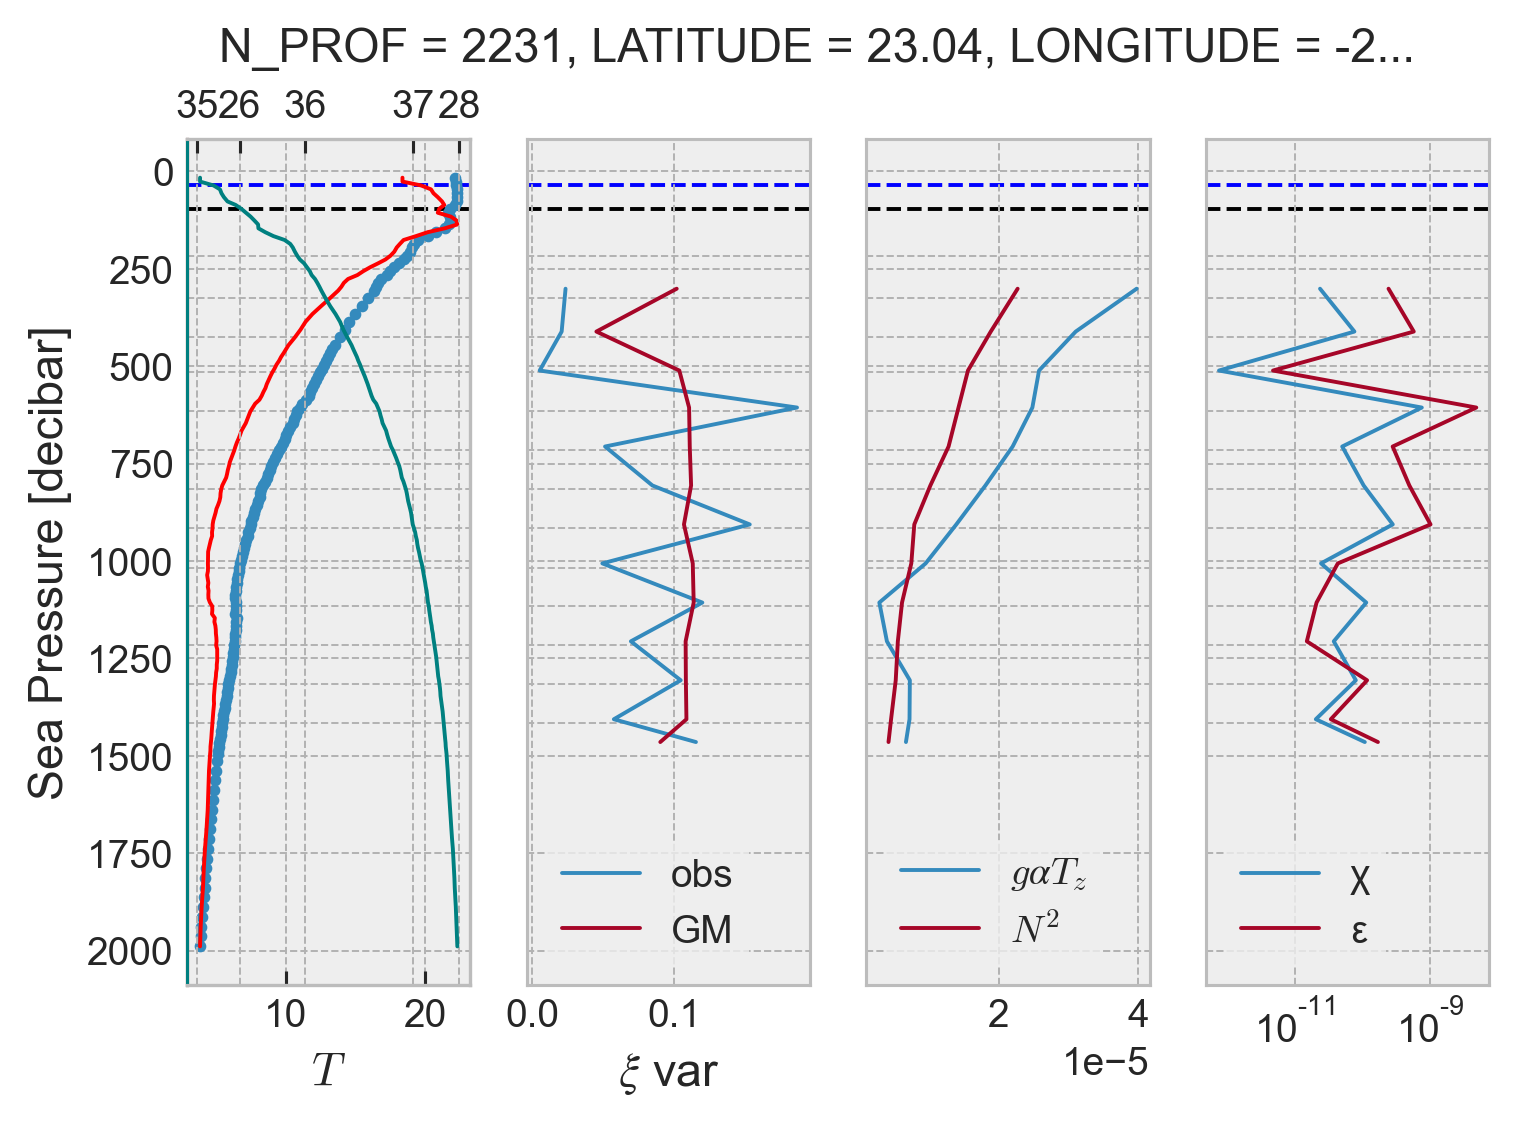

In [301]:
profile = argo.query(
    {"N_PROF": "PLATFORM_NUMBER == 6900695 & CYCLE_NUMBER == 160"}
).squeeze()
result = argomix.process_profile(profile, debug=True)

 203 —  399dbar: ξgmvar: 0.315, ξvar: 0.216, N2: 2.23e-05 K: 1.97e-06, ε: 2.16e-10
 303 —  499dbar: ξgmvar: 0.231, ξvar: 0.200, N2: 1.71e-05 K: 3.08e-06, ε: 2.58e-10
 403 —  599dbar: ξgmvar: 0.189, ξvar: 0.207, N2: 1.60e-05 K: 4.87e-06, ε: 3.83e-10
 503 —  699dbar: ξgmvar: 0.250, ξvar: 0.217, N2: 1.47e-05 K: 3.04e-06, ε: 2.19e-10
 603 —  799dbar: ξgmvar: 0.286, ξvar: 0.219, N2: 1.37e-05 K: 2.35e-06, ε: 1.58e-10
 703 —  899dbar: ξgmvar: 0.146, ξvar: 0.191, N2: 1.29e-05 K: 6.82e-06, ε: 4.31e-10
 803 —  987dbar: ξgmvar: 0.256, ξvar: 0.200, N2: 9.84e-06 K: 2.36e-06, ε: 1.14e-10
 903 — 1073dbar: ξgmvar: 0.460, ξvar: 0.169, N2: 8.63e-06 K: 5.15e-07, ε: 2.18e-11


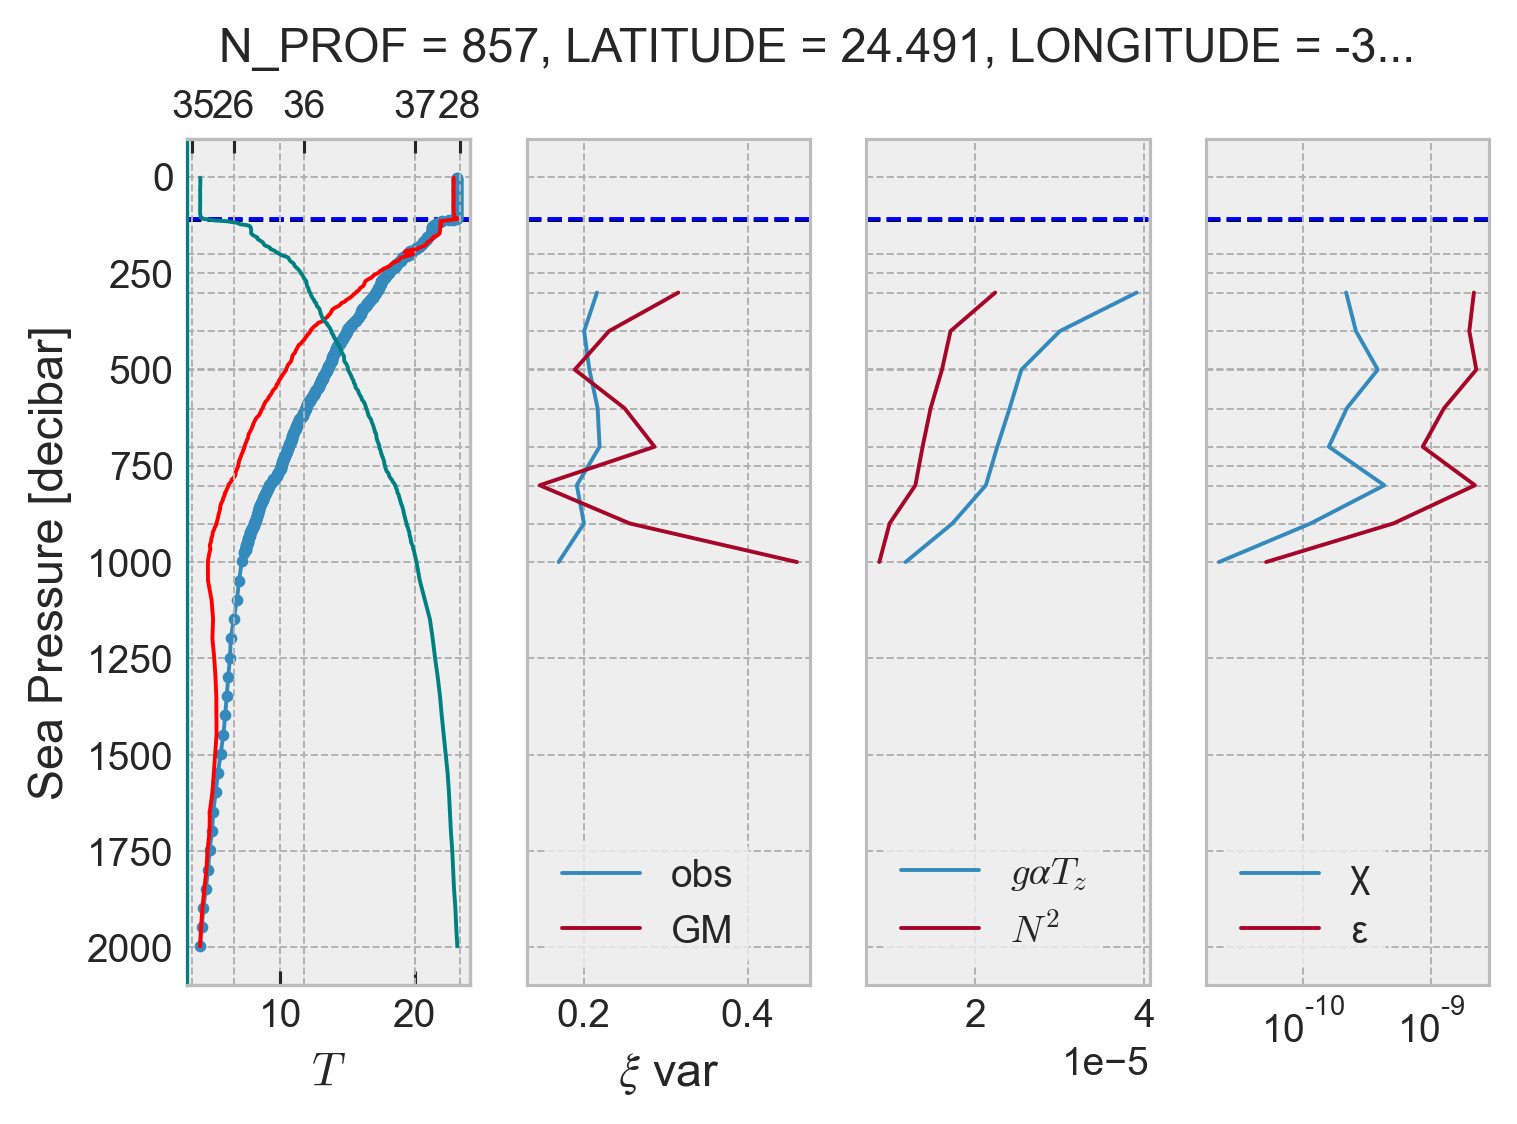

In [109]:
profile = argo.isel(N_PROF=2100)
result = argomix.process_profile(profile, debug=True)

 201 —  397dbar: ξgmvar: 0.269, ξvar: 0.217, N2: 1.73e-05 K: 2.92e-06, ε: 2.47e-10
 303 —  497dbar: ξgmvar: 0.137, ξvar: 0.219, N2: 1.57e-05 K: 1.14e-05, ε: 8.78e-10
 401 —  597dbar: ξgmvar: 0.136, ξvar: 0.215, N2: 1.43e-05 K: 1.11e-05, ε: 7.77e-10
 501 —  699dbar: ξgmvar: 0.131, ξvar: 0.208, N2: 1.42e-05 K: 1.11e-05, ε: 7.72e-10
 601 —  799dbar: ξgmvar: 0.216, ξvar: 0.219, N2: 1.46e-05 K: 4.58e-06, ε: 3.27e-10
 701 —  897dbar: ξgmvar: 0.145, ξvar: 0.207, N2: 1.44e-05 K: 9.05e-06, ε: 6.40e-10
 803 —  997dbar: ξgmvar: 0.236, ξvar: 0.209, N2: 1.23e-05 K: 3.38e-06, ε: 2.04e-10
 901 — 1099dbar: ξgmvar: 0.038, ξvar: 0.175, N2: 9.35e-06 K: 8.93e-05, ε: 4.09e-09
1001 — 1197dbar: ξgmvar: 0.087, ξvar: 0.201, N2: 8.07e-06 K: 2.19e-05, ε: 8.66e-10
1103 — 1299dbar: ξgmvar: 0.099, ξvar: 0.204, N2: 7.22e-06 K: 1.75e-05, ε: 6.19e-10
1201 — 1399dbar: ξgmvar: 0.051, ξvar: 0.200, N2: 5.85e-06 K: 6.25e-05, ε: 1.79e-09
1303 — 1499dbar: ξgmvar: 0.199, ξvar: 0.216, N2: 4.83e-06 K: 4.62e-06, ε: 1.09e-10
1403

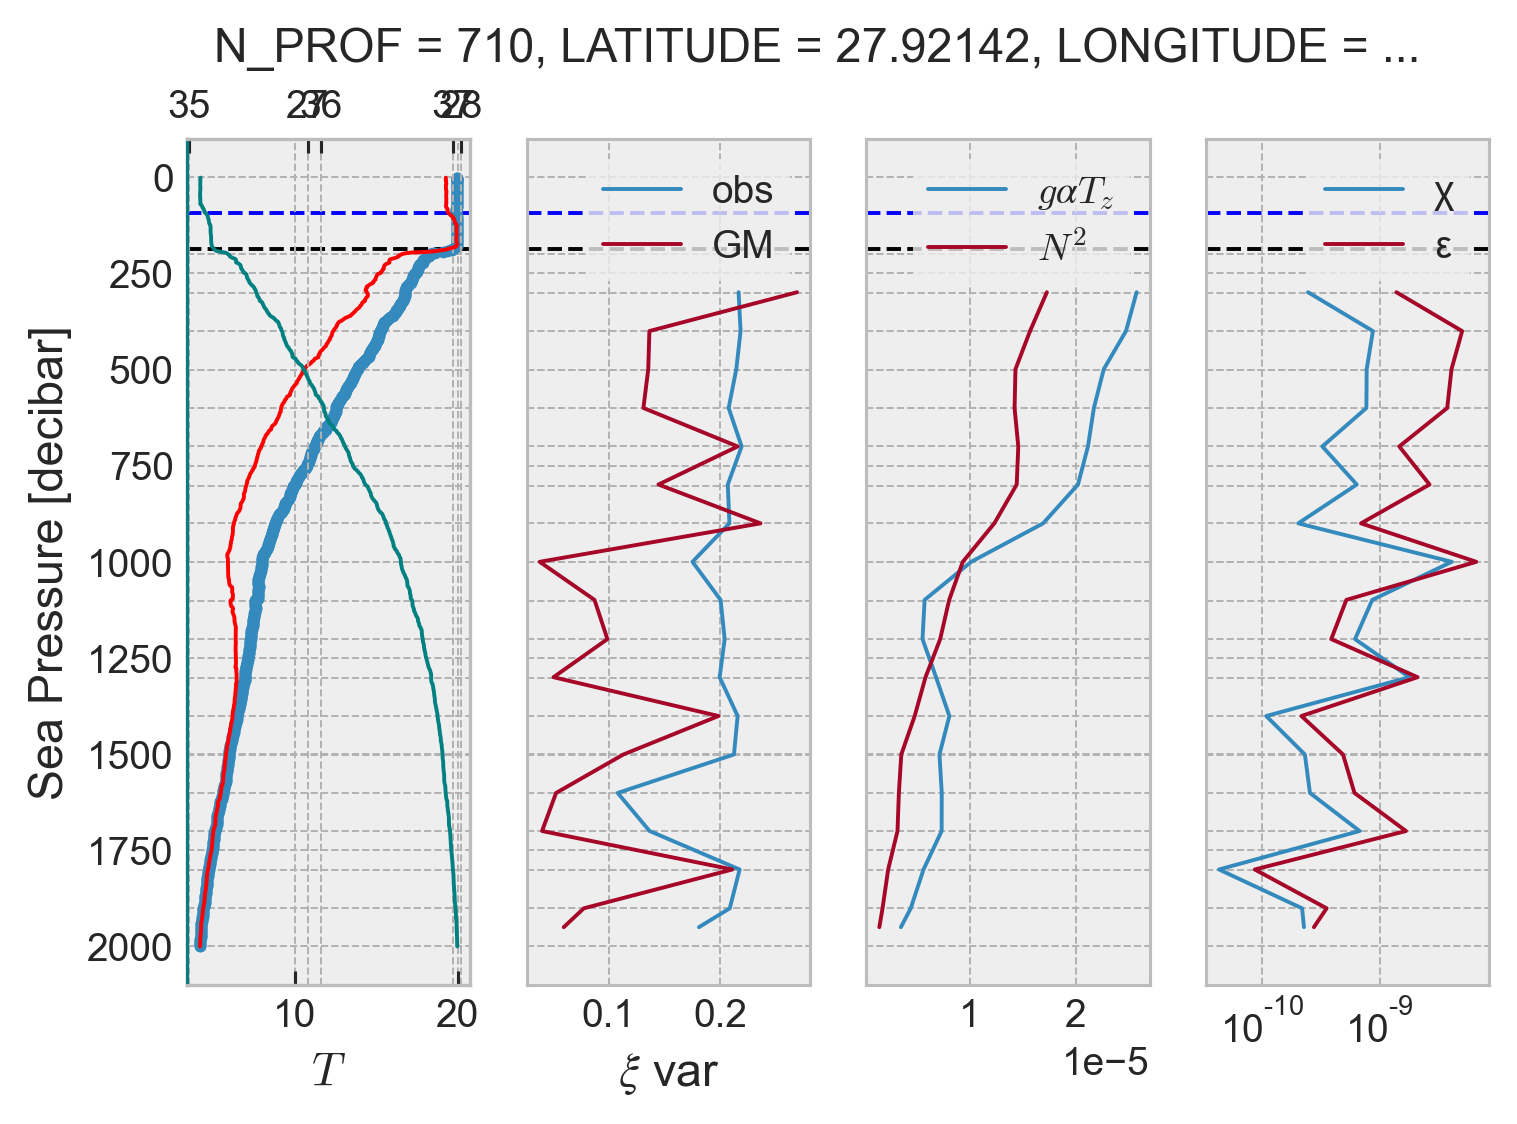

In [110]:
profile = argo.query(
    {"N_PROF": "PLATFORM_NUMBER == 4901588 & CYCLE_NUMBER == 23"}
).squeeze()
result = argomix.process_profile(profile, debug=True)

### Bad profiles

I found some bad profiles; all for the same float 6900695; and cycle numbers 160, 170 ,171, 175.

Changing from the mixsea psd to my psd fixed it :/. The input data were fine; whatever funny interpolation is done with mixsea screws things

In [474]:
mask = (combined.ε > 1).any("pressure_")
combined.isel(profile=mask)

<xarray.Dataset>
Dimensions:                (pressure_: 19, profile: 4, nbnds: 2)
Coordinates: (12/13)
  * pressure_              (pressure_) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18
    flag                   (profile, pressure_) float64 5.0 5.0 5.0 ... -2.0 nan
    pressure               (profile, pressure_) float64 282.7 414.5 ... nan nan
    npts                   (profile, pressure_) float64 15.0 13.0 ... 4.0 nan
    γmean                  (profile, pressure_) float64 26.71 26.92 ... nan nan
    latitude               (profile) float64 23.04 23.05 23.17 23.56
    ...                     ...
    γ_bounds               (profile, pressure_, nbnds) float64 26.5 ... nan
    p_bounds               (profile, pressure_, nbnds) float64 206.0 ... nan
    CONFIG_MISSION_NUMBER  (profile) int64 2 2 2 2
    PLATFORM_NUMBER        (profile) int64 6900695 6900695 6900695 6900695
    CYCLE_NUMBER           (profile) int64 160 170 171 175
    DIRECTION              (profile) <U1 'A' 'A' 'A' 'A'
Dimensions without coordinates: profile, nbnds
Data variables: (12/13)
    ε                      (profile, pressure_) float64 2.364e-11 ... nan
    Kρ                     (profile, pressure_) float64 2.215e-07 ... nan
    N2mean                 (profile, pressure_) float64 2.177e-05 ... nan
    ξvar                   (profile, pressure_) float64 0.03379 ... nan
    ξvargm                 (profile, pressure_) float64 0.1436 0.05839 ... nan
    Tzlin                  (profile, pressure_) float64 0.02425 0.01908 ... nan
    ...                     ...
    Tmld                   (profile) float64 96.0 56.0 46.0 45.0
    σmld                   (profile) float64 36.0 46.0 46.0 36.0
    Tmode                  (profile) float64 146.0 66.0 56.0 55.0
    σmode                  (profile) float64 106.0 66.0 56.0 55.0
    χ                      (profile, pressure_) float64 2.333e-10 ... nan
    KtTz                   (profile, pressure_) float64 5.082e-09 ... nan